In [ ]:
# -*- coding: utf-8 -*-


"""
importing all the neccessary libraries

@author: Steven 
@affiliation: Unviersity of Auckland

"""

## Part 1 机器学习Fitness函数

### 1.1 随机生成结构

In [7]:
import numpy as np
from population import Population
import ase.db
from ase import Atoms
from ase.data import atomic_numbers
from ase.io import read, write
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones as LJ

from ase.ga import get_raw_score
from ase.ga.data import PrepareDB
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.startgenerator import StartGenerator
from ase.ga.data import DataConnection
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.offspring_creator import OperationSelector
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.standardmutations import (RattleMutation, StrainMutation,
                                      RotationalMutation,
                                      RattleRotationalMutation)
from ase.ga.soft_mutation import SoftMutation
from ase.ga.data import PrepareDB


# Number of randomly generated structures
N = 30

# The building blocks
blocks = [('N2', 8)]
# By writing 'N2', the generator will automatically
# get the N2 geometry using ase.build.molecule.

# A guess for the cell volume in Angstrom^3
box_volume = 30. * 8

# The cell splitting scheme:
splits = {(2,): 1, (1,): 1}

# The minimal interatomic distances which the
# initial structures must satisfy. We can take these
# a bit larger than usual because these minimal
# distances will only be applied intermolecularly
# (and not intramolecularly):
Z = atomic_numbers['N']
blmin = closest_distances_generator(atom_numbers=[Z],
                                    ratio_of_covalent_radii=1.3)

# The bounds for the randomly generated unit cells:
cellbounds = CellBounds(bounds={'phi': [30, 150], 'chi': [30, 150],
                                'psi': [30, 150], 'a': [3, 50],
                                'b': [3, 50], 'c': [3, 50]})

# The familiar 'slab' object, here only providing
# the PBC as there are no atoms or cell vectors
# that need to be applied.
slab = Atoms('', pbc=True)

# create the starting population
sg = StartGenerator(slab, blocks, blmin, box_volume=box_volume,
                    cellbounds=cellbounds, splits=splits,
                    number_of_variable_cell_vectors=3,
                    test_too_far=False)

# Initialize the database
da = PrepareDB(db_file_name='gadb.db', simulation_cell=slab,
               stoichiometry=[Z] * 16)
da1 = PrepareDB(db_file_name='gadb1.db', simulation_cell=slab,
               stoichiometry=[Z] * 16)
da2 = PrepareDB(db_file_name='gadb2.db', simulation_cell=slab,
               stoichiometry=[Z] * 16)

# Generate the new structures
# and add them to the database
for i in range(N):
    a = sg.get_new_candidate()
    da.add_unrelaxed_candidate(a)
    
da = DataConnection('gadb.db')
write('unrelaxed_candidates.xyz', da.get_all_unrelaxed_candidates())


### 1.2 计算Fitness函数

In [9]:
from ofp_comparator import OFPComparator

# Various items needed for initializing the genetic operators
da = DataConnection('gadb.db')
da2 = DataConnection('gadb2.db')

slab = da.get_slab()
atom_numbers_to_optimize = da.get_atom_numbers_to_optimize()
n_top = len(atom_numbers_to_optimize)
blmin = closest_distances_generator(atom_numbers_to_optimize, 1.0)
cellbounds = CellBounds(bounds={'phi': [30, 150], 'chi': [30, 150],
                                'psi': [30, 150]})


# Relaxing the initial candidates
while da.get_number_of_unrelaxed_candidates() > 0:
    a = da.get_an_unrelaxed_candidate()
    a.calc = LJ()
    print('Relaxing starting candidate \n {0}'.format(a.info['confid']))
    dyn = BFGS(a, trajectory=None, logfile=None)
    dyn.run(fmax=0.05, steps=300)
    a.info['key_value_pairs']['raw_score'] = -a.get_potential_energy()
    da.add_relaxed_step(a)
    da2.add_relaxed_step(a)

comp = OFPComparator(n_top=n_top, dE=1.0, cos_dist_max=5e-3, rcut=10.,
                     binwidth=0.05, pbc=[True, True, True], sigma=0.05,
                     nsigma=4, recalculate=False)
# The population
population = Population(data_connection=da,
                        population_size=30,
                        comparator=comp,
                        logfile='log.txt')



# calculate the fitness value and fingerprint matrix
da1 = ase.db.connect('gadb1.db')
finger = np.zeros((1,200))

for i in range(len(population.pop)):
    print('Now starting configuration number \n {0}'.format(i), flush=True)
    fitness_value = population.get_fitness(range(len(population.pop)), with_history=True)
    all_relaxed_ids = [t.id for t in da.c.select(relaxed=1)]
    atoms = da.get_atoms(all_relaxed_ids[i])
    da1.write(atoms, fitness=fitness_value[i], fitted=1)
    finger_matrix = comp.take_fingerprints(atoms)
    finger = np.append(finger, finger_matrix[0][(7,7)].reshape((1,200)), axis=0)
    
finger = np.delete(finger, 1, axis = 0)
print('The fitness value list \n {0}'.format(fitness_value))
print('The fingerprint matrix \n {0}'.format(finger))

write('relaxed_candidates.xyz', da.get_all_relaxed_candidates())

Relaxing starting candidate 
 3
Relaxing starting candidate 
 4
Relaxing starting candidate 
 5
Relaxing starting candidate 
 6
Relaxing starting candidate 
 7
Relaxing starting candidate 
 8
Relaxing starting candidate 
 9
Relaxing starting candidate 
 10
Relaxing starting candidate 
 11
Relaxing starting candidate 
 12
Relaxing starting candidate 
 13
Relaxing starting candidate 
 14
Relaxing starting candidate 
 15
Relaxing starting candidate 
 16
Relaxing starting candidate 
 17
Relaxing starting candidate 
 18
Relaxing starting candidate 
 19
Relaxing starting candidate 
 20
Relaxing starting candidate 
 21
Relaxing starting candidate 
 22
Relaxing starting candidate 
 23
Relaxing starting candidate 
 24
Relaxing starting candidate 
 25
Relaxing starting candidate 
 26
Relaxing starting candidate 
 27
Relaxing starting candidate 
 28
Relaxing starting candidate 
 29
Relaxing starting candidate 
 30
Relaxing starting candidate 
 31
Now starting configuration number 
 0
Now starting

### 1.3 机器学习Fitness函数

[[ 4.69041576  4.69041576  4.69041576 ...  0.222979    0.59099193
   2.05900217]
 [-0.21320072 -0.21320072 -0.21320072 ... -0.97482812 -1.06530738
  -1.41559208]
 [-0.21320072 -0.21320072 -0.21320072 ... -0.07793781  0.31689696
   0.93940401]
 ...
 [-0.21320072 -0.21320072 -0.21320072 ...  0.12204137 -0.20887855
  -0.53472886]
 [-0.21320072 -0.21320072 -0.21320072 ...  1.94693845  2.29338185
   2.12635882]
 [-0.21320072 -0.21320072 -0.21320072 ... -0.6376561  -0.63538759
  -0.69808717]]
[ 1.59770078  1.28568407  1.26857119  1.18034437  1.15144398  1.1247799
  0.06911789  0.03073717  0.83385629  0.8002881   0.42797948 -0.44355169
  0.10411944 -0.66520374 -0.67408287 -0.05111545 -0.74911322 -1.24738045
 -1.25786571 -1.09736365 -0.38524015 -1.47867511 -1.82503063]
Optimized kernel: [{'type': 'gaussian', 'width': [3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.063167485787863, 39.68364191006405, 284.00949733967377, 161.77543406281418, 0.8633688654283

(-1.1, 23.1, 0.08112223456028246, 0.9188777648722264)

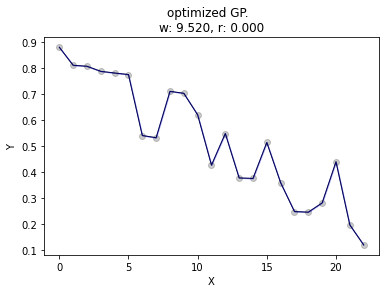

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from catlearn.preprocess.scaling import standardize, target_standardize
from catlearn.regression import GaussianProcess
from catlearn.regression.cost_function import get_error


# Store standard deviations of the training data and targets.
stdx = np.std(finger)
stdy = np.std(fitness_value)
tstd = 2.

# Standardize the training targets.
std = standardize(train_matrix=finger)
train_targets = target_standardize(fitness_value)
print(std['train'])
print(train_targets['target'])

# Define prediction parameters.
sdt1 = 0.001
# Too large width results in a biased model.
w1 = 3.0
kdict = [{'type': 'gaussian', 'width': w1}]
# Set up the prediction routine.
gp = GaussianProcess(kernel_list=kdict, regularization=sdt1,
                     train_fp=std['train'],
                     train_target=train_targets['target'],
                     optimize_hyperparameters=True)

print('Optimized kernel:', gp.kernel_list)
print(-gp.theta_opt['fun'])

# Do predictions.
under_fit = gp.predict(test_fp=std['train'], uncertainty=True)
# Scale predictions back to the original scale.
under_prediction = np.vstack(under_fit['prediction']) * \
    train_targets['std'] + train_targets['mean']
under_uncertainty = np.vstack(under_fit['uncertainty_with_reg']) * \
    train_targets['std']
# Get average errors.
error = get_error(under_prediction.reshape(-1), fitness_value)
print('Gaussian linear regression prediction:', error['absolute_average'])
print(under_fit['prediction'])
# Get confidence interval on predictions.
upper = under_prediction + under_uncertainty * tstd
lower = under_prediction - under_uncertainty * tstd


# Store the known underlying function for plotting.
linex = np.linspace(np.min([i for i in range(finger.shape[0])]), np.max([i for i in range(finger.shape[0])]), len(population.pop))
liney = fitness_value

plt.figure(0)
plt.plot(linex, liney, '-', lw=1, color='black')
plt.plot([i for i in range(finger.shape[0])], fitness_value, 'o', alpha=0.2, color='black')
plt.plot([i for i in range(finger.shape[0])], under_prediction, 'b-', lw=1, alpha=0.4)
plt.fill_between(np.hstack([i for i in range(finger.shape[0])]), np.hstack(upper), np.hstack(lower),
                interpolate=True, color='blue',
                alpha=0.2)
plt.title('optimized GP.  \n' +
          'w: {0:.3f}, r: {1:.3f}'.format(w1 * stdx,
                                          sdt1 * stdy))
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('tight')


## Part 2 遗传算法

In [15]:
import numpy as np
from ase.io import write
from ase.ga import get_raw_score
from ase.ga.data import DataConnection
from population import Population
from ase.ga.utilities import closest_distances_generator, CellBounds
from ase.ga.ofp_comparator import OFPComparator
from ase.ga.offspring_creator import OperationSelector
from ase.ga.cutandsplicepairing import CutAndSplicePairing
from ase.ga.standardmutations import (RattleMutation, StrainMutation,
                                      RotationalMutation,
                                      RattleRotationalMutation)
from ase.ga.soft_mutation import SoftMutation
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones as LJ


da2 = DataConnection('gadb2.db')
slab = da2.get_slab()
atom_numbers_to_optimize = da2.get_atom_numbers_to_optimize()
n_top = len(atom_numbers_to_optimize)
blmin = closest_distances_generator(atom_numbers_to_optimize, 1.0)
cellbounds = CellBounds(bounds={'phi': [30, 150], 'chi': [30, 150],
                                'psi': [30, 150]})

pairing = CutAndSplicePairing(slab, n_top, blmin, p1=1., p2=0.,
                              minfrac=0.15, cellbounds=cellbounds,
                              number_of_variable_cell_vectors=3,
                              use_tags=True)

rattlemut = RattleMutation(blmin, n_top, rattle_prop=0.3, rattle_strength=0.5,
                           use_tags=True)

strainmut = StrainMutation(blmin, stddev=0.7, cellbounds=cellbounds,
                           use_tags=True)

rotmut = RotationalMutation(blmin, fraction=0.3, min_angle=0.5 * np.pi)

rattlerotmut = RattleRotationalMutation(rattlemut, rotmut)

blmin_soft = closest_distances_generator(atom_numbers_to_optimize, 0.8)
softmut = SoftMutation(blmin_soft, bounds=[2., 5.], use_tags=True)

operators = OperationSelector([5, 1, 1, 1, 1, 1], \
                              [pairing, rattlemut, strainmut, rotmut, rattlerotmut, softmut])

comp = OFPComparator(n_top=n_top, dE=1.0, cos_dist_max=5e-3, rcut=10.,
                     binwidth=0.05, pbc=[True, True, True], sigma=0.05,
                     nsigma=4, recalculate=False)
# The population
population = Population(data_connection=da2,
                        population_size=23,
                        comparator=comp,
                        logfile='log.txt')

current_pop = population.get_current_population()
strainmut.update_scaling_volume(current_pop, w_adapt=0.5, n_adapt=4)
pairing.update_scaling_volume(current_pop, w_adapt=0.5, n_adapt=4)

# Test a few new candidates
n_to_test = 30
fit = under_fit['prediction']
print(len(fit))
print(len(population.pop))

for step in range(n_to_test):
    print('Now starting configuration number {0}'.format(step), flush=True)

    # Generate a new candidate
    a3 = None
    while a3 is None:
        a1, a2 = population.get_two_candidates(fit)
        a3, desc = operators.get_new_individual([a1, a2])
    print(a1, a2)
    print(a3, desc)
    # Relax it and add to database
    da2.add_unrelaxed_candidate(a3, description=desc)
    a3 = da2.get_an_unrelaxed_candidate()
    a3.calc = LJ()
    print('Relaxing starting candidate {0}'.format(a.info['confid']))
    dyn = BFGS(a3, trajectory=None, logfile=None)
    dyn.run(fmax=0.05, steps=100)
    a3.info['key_value_pairs']['raw_score'] = -a.get_potential_energy()
    da2.add_relaxed_step(a3)

    # Update the population
    population.update()
    current_pop = population.get_current_population()
    write('current_population.traj', current_pop)

    # Update the strain mutation and pairing operators
    if step % 30 == 0:
        strainmut.update_scaling_volume(current_pop, w_adapt=0.5,
                                        n_adapt=4)
        pairing.update_scaling_volume(current_pop, w_adapt=0.5, n_adapt=4)

    # Print out information for easier follow-up/analysis/plotting:
    print('Step %d %s %.3f %.3f %.3f' % (
        step, desc, get_raw_score(a1), get_raw_score(a2), get_raw_score(a3)))

    print('Step %d highest raw score in pop: %.3f' %
          (step, get_raw_score(current_pop[0])))

print('GA finished after step %d' % step)
hiscore = get_raw_score(current_pop[0])
print('Highest raw score = %8.4f eV' % hiscore)
write('all_candidates.traj', da2.get_all_relaxed_candidates())
write('current_population.traj', current_pop)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 99)